In [1]:
# importing libraries for the API connection

import tweepy
from tweepy.auth import OAuthHandler
import pandas as pd
import numpy as np

In [2]:
# generating a dict with the keys for the API connection

secrets_dict={}
secrets_file = open('tweepy-keys.txt')
for line in secrets_file:
  (key,value) = line.split(':')
  secrets_dict[key] = value[:-1]

In [3]:
# creating the API cursor

auth = tweepy.OAuthHandler(secrets_dict['API Key'], secrets_dict['API secret'])
auth.set_access_token(secrets_dict['Access token'], secrets_dict['Access secret'])
api = tweepy.API(auth)

In [4]:
def scrape(words, date_since, numtweet):

# Creating DataFrame using pandas
  db = pd.DataFrame(columns=['username', 'description', 'location', 'following',
              'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'])

# We are using .Cursor() to search through twitter for the required tweets.
# The number of tweets can be restricted using .items(number of tweets)
  tweets = tweepy.Cursor(api.search, q=words, lang="en",
            since=date_since, tweet_mode='extended').items(numtweet)

# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes that you can access to
# get information about each tweet
  list_tweets = [tweet for tweet in tweets]

# Counter to maintain Tweet Count
  i = 1

# we will iterate over each tweet in the list for extracting information about each tweet
  for tweet in list_tweets:
    username = tweet.user.screen_name
    description = tweet.user.description
    location = tweet.user.location
    following = tweet.user.friends_count
    followers = tweet.user.followers_count
    totaltweets = tweet.user.statuses_count
    retweetcount = tweet.retweet_count
    hashtags = tweet.entities['hashtags']
  
# Retweets can be distinguished by a retweeted_status attribute,
# in case it is an invalid reference, except block will be executed
    try:
      text = tweet.retweeted_status.full_text
    except AttributeError:
      text = tweet.full_text
    hashtext = list()
    for j in range(0, len(hashtags)):
      hashtext.append(hashtags[j]['text'])

    # Here we are appending all the extracted information in the DataFrame
    ith_tweet = [username, description, location, following,
          followers, totaltweets, retweetcount, text, hashtext]
    db.loc[len(db)] = ith_tweet

  

# we will save our database as a CSV file.
  return db

In [5]:
# define forloop that scrapes the necessary tweets and concatenates them

import time # twitter limitates the amount of scrapping you can do, so we need to do timesleep
from datetime import date

# politic is the list of politicians to scrape for
# Enter Date since The Tweets are required in yyyy-mm-dd
# The minutes its the time it will spend between each iteration of the scrape
# numtweet is the number of tweets for each hashtag
# file is the older file that i might have and i want to concatenate with

# WARNING: Remove the default politicians before deploying

def scrapping_engine(date_,politic=['#JoeBiden','#BernieSanders','#MikePence','#TedCruz'], minutes=15, numtweet=500, file=0):

    # we need to create a dataframe to deposit the tweets that we scrape

    columns = ['target','Unnamed: 0', 'username', 'description', 'location', 'following',
           'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags'] # this are the columns that for the dataframe

    politic_df = pd.DataFrame(dict(), columns=columns) # creation of the dataframe

    # this is the loop for the scrapping of every politician

    for element in politic:
        subdata = scrape(element, date_, numtweet)
        subdata['target'] = element
        politic_df = politic_df.append(subdata)
        time.sleep(60 * minutes) # need to take it easy!
        
    csv = file
    
    politic_df = appending(politic_df, csv)
    
    spams_count = dict(politic_df['text'].value_counts())

    spams = []

    for x,y in spams_count.items():
        if y > 1:
            spams.append(x)

    counter = 0

    politic_df = politic_df.reset_index()

    for element in politic_df['text']:
        if element in spams:
            politic_df.drop(index=counter, inplace=True)
        counter += 1
    
    new_date = 'scraped_from_' + date_ + '_to_' + str(date.today())
    
    if csv != 0:
        politic_df.to_csv(new_date + '.csv', index_label=False)
        return politic_df
    else:
        politic_df.to_csv(new_date + '.csv', index_label=False)
        return politic_df


In [6]:
# define a function that adds the newly scraped file to the rest

def appending(db, file):
    older = pd.read_csv(file)
    return db.append(older) # returns the new database appended

In [7]:
def politicians_input():
    print('Enter the politicians names (separated by comma, E.g: ´Joe Biden, Bernie Sanders´): ')
    string_ = input()
    string = string_.replace(' ','')
    list_strings = string.split(',')

    return [('#' + x) for x in list_strings]

In [8]:
to_scrape = politicians_input()

# do a function for date input

politic_df = scrapping_engine('2021-07-24', to_scrape, 15, 500, 'scraped_from_2021-07-22_to_2021-07-23.csv')

Enter the politicians names (separated by comma, E.g: ´Joe Biden, Bernie Sanders´): 
Joe Biden, Bernie Sanders, Ted Cruz, Mike Pence


In [9]:
politic_df.shape

(1768, 14)

In [10]:
politic_df.head()

,index,target,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,Unnamed: 0.1
0,0,#JoeBiden,NaN,Michell81478626,"I live in Minnesota, I love my cat, dog and bi...","Minnesota, USA",69,12,60,2,#Congress #chuckSchumer #nancyPelosi #democrat...,"['Congress', 'chuckSchumer', 'nancyPelosi', 'd...",NaN
2,2,#JoeBiden,NaN,DerekOsheaShow,Derek O'Shea Show Politically Homeless Daily C...,Everywhere you want to be,3435,781,5095,0,Who is Defunding Police | Conspiracy Theories ...,"['Covid19News', 'JoeBiden', 'BreakingNews', 'p...",NaN
3,3,#JoeBiden,NaN,Tim20026046,"White-haired, upper fifties, libertarian dad, ...",NaN,485,17,4239,98,"#JoeBiden Tells The World Another Whopper ""You...",['JoeBiden'],NaN
4,4,#JoeBiden,NaN,lilgoddamn_III,#bitcoin\n§LilGoddamn,The Moon 🌕,900,297,28972,57,Democrats Future Agenda...\n\n#NacyPelosi :\nL...,"['NacyPelosi', 'JoeBiden']",NaN
5,5,#JoeBiden,NaN,LisaMaret,"Founder, Tea Party WDC ""Return 2 commerce, cha...",Alexandria Va,1446,1735,69535,0,"@taxreformer Big surprise, the IRS doesn't aud...","['LarcenousClass', 'Democrats', 'JoeBiden', 'P...",NaN


In [10]:
# now we need to clean the tweets
# importing the necessaire packages


import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('wordnet')
from nltk.corpus import wordnet

nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# the main cleaning step

def clean_up(s):
    element1 = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', s).lower() # remove links
    element2 = re.sub('[^a-zA-Z0-9]', ' ', element1) # remove non character symbols
    element3 = re.sub('amp', '', element2) # twitter has &amp as a special character
    element4 = re.sub('joe biden', 'joebiden', element3)
    element5 = re.sub('bernie sanders', 'berniesanders', element4)
    element6 = re.sub('ted cruz', 'tedcruz', element5)
    element7 = re.sub('mike pence', 'mikepence', element6)
    element8 = re.sub('joebiden|berniesanders|tedcruz|mikepence','', element7)
    return (re.sub('\d+',' ',element8)) # remove any digits and lowercase everything

In [12]:
# tokenize the text

def tokenize(s):
    return word_tokenize(s)

In [13]:
# categorize function to help the next function that is lemmatize

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # gets first letter of POS categorization
    tag_dict = {"J": wordnet.ADJ, 
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # get returns second argument if first key does not exist

In [14]:
# lemmatize to reduce the word to it most radical form

def lemmatize(l):
  
    lem = WordNetLemmatizer()
    lemmatized = [lem.lemmatize(w,get_wordnet_pos(w)) for w in l]
    
    return lemmatized

In [15]:
# remove the stop words

def remove_stopwords(l):
    
    filtered_sentence = []
    
    for w in l:
        if len(w) > 1:
            if w not in stopwords.words('english'):
                filtered_sentence.append(w)
    
    return filtered_sentence

In [16]:
# remove elements with 1 len

def remove_1len(row):

    lista = row

    for s in lista:
        if len(s) < 2:
            lista.remove(s)
            
    return lista

In [17]:
def clear_p(row):
    
    p = ['joebiden','berniesanders','tedcruz','mikepence']
    
    sublist = row
    
    for word in sublist:
        if word in p:
            sublist.remove(word)
                
    return sublist

In [18]:
# function that combines all of the cleaning functions and does everything

def cleaning_engine(df,column='text'):
    df['text_processed'] = df[column].apply(clean_up)
    df['text_processed'] = df['text_processed'].apply(tokenize)
    df['text_processed'] = df['text_processed'].apply(lemmatize)
    df['text_processed'] = df['text_processed'].apply(remove_stopwords)
    df['text_processed'] = df['text_processed'].apply(clear_p)
    return df['text_processed'].apply(remove_1len)
    

In [19]:
# applying the cleaning engine

politic_df['text_processed'] = cleaning_engine(politic_df)

In [21]:
politic_df.shape

(1768, 15)

In [23]:
# delete the spams that our initial scrape was not able to

counter = 0

politic_df = politic_df.rename(columns={'index':'index1'})

politic_df = politic_df.reset_index()

for tweet in politic_df['text_processed']:
    if 'free' in tweet:
        politic_df.drop(index=counter, inplace=True)
    elif 'kingjames' in tweet:
        politic_df.drop(index=counter, inplace=True)
    elif 'shipping' in tweet:
        politic_df.drop(index=counter, inplace=True)
        
    counter += 1

In [25]:
counter = 0

politic_df = politic_df.rename(columns={'index':'index2'})

politic_df = politic_df.reset_index()

for element in politic_df['text_processed']:
    if len(element) < 2:
        politic_df.drop(index=counter, inplace=True)
    counter += 1

In [26]:
politic_df.shape

(1627, 17)

In [27]:
for element in politic_df['text_processed']:
    if 'free' in element:
        print(element)

In [28]:
# for some functions we actually need the the tweet not tokenized!

politic_df['text_preprocessed'] = politic_df['text_processed'].apply(lambda x: ' '.join(x))

In [29]:
# now that we have the tweet in the way we want lets get rid of the other columns

features = politic_df[['target','text_processed','text_preprocessed']].reset_index()
features.head()

,index,target,text_processed,text_preprocessed
0,0,#JoeBiden,"[brexit, eu, uk, criticise, flaw, protocol, ap...",brexit eu uk criticise flaw protocol approach ...
1,1,#JoeBiden,"[elder, abuse, simple, yet, medium, protection...",elder abuse simple yet medium protection racke...
2,2,#JoeBiden,"[palestinian, attend, funeral, child, muhammad...",palestinian attend funeral child muhammad al a...
3,3,#JoeBiden,"[video, father, son, hunterbiden, crackhead, c...",video father son hunterbiden crackhead crack m...
4,4,#JoeBiden,"[thursdaythoughts, blame, freudian, slip, late...",thursdaythoughts blame freudian slip late blun...


In [30]:
features.shape

(1627, 4)

In [31]:
# now lets start working on our features
# the first feature that we are interested in is the sentiment
# is the tweet negative, neutral or positive?


from nltk.sentiment import SentimentIntensityAnalyzer # this is the package that does the trick
sia = SentimentIntensityAnalyzer()

def is_positive(tweet):
    if sia.polarity_scores(tweet)["compound"] > 0: # when the compound score is greater than 0 the tweet is positive
        return 1 # 1 for positive
    return 0 # 0 for negative or neutral

features['sentiment'] = features['text_preprocessed'].apply(is_positive)

In [32]:
features.head()

,index,target,text_processed,text_preprocessed,sentiment
0,0,#JoeBiden,"[brexit, eu, uk, criticise, flaw, protocol, ap...",brexit eu uk criticise flaw protocol approach ...,0
1,1,#JoeBiden,"[elder, abuse, simple, yet, medium, protection...",elder abuse simple yet medium protection racke...,0
2,2,#JoeBiden,"[palestinian, attend, funeral, child, muhammad...",palestinian attend funeral child muhammad al a...,0
3,3,#JoeBiden,"[video, father, son, hunterbiden, crackhead, c...",video father son hunterbiden crackhead crack m...,0
4,4,#JoeBiden,"[thursdaythoughts, blame, freudian, slip, late...",thursdaythoughts blame freudian slip late blun...,0


In [33]:
# other thing that we want to capture is the actual intensity of the tweet
# some words are more intense than others
# the package is the same, but now we will use the actual compound score

def intensity(tweet):
    return (abs(sia.polarity_scores(tweet)["compound"])+1)**2 # to give more importance the intense tweets we are going to square it

features['intensity'] = features['text_preprocessed'].apply(intensity)


In [34]:
features.shape

(1627, 6)

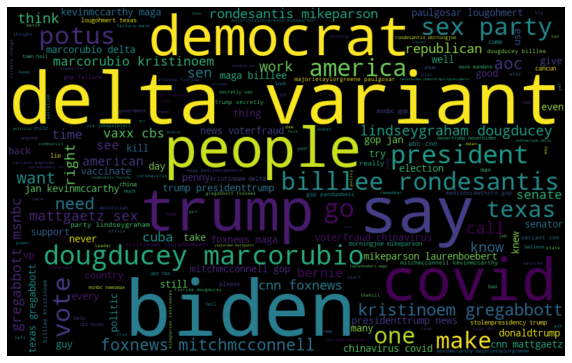

In [35]:
# lets see the word cloud of our tweets to understand a bit more our data

all_words = ' '.join([text for text in features['text_preprocessed']]) 
import matplotlib.pyplot as plt

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [36]:
# another feature that is really important is the context of the tweet
# to capture that we agre going to use the package gensim with the doc2vec model

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence
import gensim

# create a function to label the tweets

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(features['text_processed']) # label all the tweets


# initialize the model

model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=50, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=2, # Ignores all words with total frequency lower than 2.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

# build the vocab with the labeled tweets

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(features['text_preprocessed']), epochs=5)

C:\Users\DELL\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
<ipython-input-36-2ccad80f82fd>:14: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  output.append(LabeledSentence(s, ["tweet_" + str(i)]))
100%|██████████| 1627/1627 [00:00<?, ?it/s]


In [37]:
# now that we have our model lets create a matrix for every tweet in our data

docvec_arrays = np.zeros((len(features['text_processed']), 50)) 
for i in range(len(features)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,50))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(1627, 50)

In [38]:
# we are now joining the features that we had with this new matrix that contains the semantic context of the tweets

target_features_df = pd.concat([features, docvec_df], axis=1)

In [39]:
target_features_df.shape

(1627, 56)

In [40]:
# we dont need anymore our tweet itself, the sentiment, intensity and the context is transmitted in our features

target_features_df.drop(columns=['text_processed','text_preprocessed'], inplace=True)

In [41]:
target_features_df

,index,target,sentiment,intensity,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,0,#JoeBiden,0,2.074752,-0.483981,-0.027056,-0.200022,0.255384,-0.070296,0.547573,...,-0.114459,0.347432,0.073931,-0.081334,0.131832,0.033227,-0.566334,-0.141491,0.088778,-0.092345
1,1,#JoeBiden,0,3.247204,-0.186100,-0.010843,-0.076094,0.099734,-0.023237,0.200135,...,-0.046358,0.136954,0.020955,-0.033023,0.051361,0.007321,-0.213739,-0.060626,0.039392,-0.037489
2,2,#JoeBiden,0,1.852865,-0.305612,-0.014040,-0.126989,0.181376,-0.050584,0.355108,...,-0.085183,0.239893,0.053065,-0.061716,0.073222,0.012228,-0.356560,-0.095371,0.067988,-0.074462
3,3,#JoeBiden,0,1.000000,-0.114698,-0.009597,-0.057751,0.048895,-0.026105,0.158166,...,-0.037702,0.091266,0.034124,-0.010796,0.039207,0.007013,-0.161383,-0.041303,0.014269,-0.013942
4,4,#JoeBiden,0,2.686649,-0.179399,-0.013433,-0.093667,0.034409,-0.054845,0.230969,...,-0.039504,0.127230,0.057240,0.022201,0.052409,0.008057,-0.204442,-0.065839,0.014407,-0.019506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1622,1635,#TedCruz,1,2.790570,-0.109633,-0.002779,-0.083098,-0.000748,-0.058344,0.123729,...,-0.031090,0.058634,0.024558,0.034868,0.023338,0.004933,-0.128573,-0.045621,-0.014177,-0.005721
1623,1636,#TedCruz,0,1.503812,-0.124238,0.004464,-0.074856,0.006056,-0.067559,0.149360,...,-0.029288,0.057659,0.026669,0.034603,0.025240,0.005615,-0.145738,-0.050461,-0.014123,-0.015062
1624,1637,#TedCruz,1,3.692931,-0.096450,-0.006766,-0.074707,-0.007460,-0.051314,0.120165,...,-0.013671,0.049815,0.025629,0.027036,0.016351,0.011838,-0.107772,-0.046412,-0.012002,-0.000692
1625,1638,#TedCruz,1,3.692931,-0.171004,-0.016306,-0.079927,0.073906,-0.029210,0.180696,...,-0.035671,0.126792,0.021216,-0.020676,0.039420,0.016600,-0.195103,-0.050877,0.026783,-0.030185


In [42]:
# for purpose of using colours in our plots, we need to turn the target into ints

def labelization(row):
    if row == '#JoeBiden':
        return 0
    elif row == '#BernieSanders':
        return 1
    elif row == '#TedCruz':
        return 2
    elif row == '#MikePence':
        return 3

In [43]:
# we want to standardize the features for improving the model

from sklearn.preprocessing import StandardScaler

X = target_features_df.drop(columns=['index','target'])

# create object

scaler = StandardScaler()

# fit

scaler.fit(X)

# transform 

X_scaled = scaler.transform(X)

In [44]:
np.isnan(X_scaled).sum()

0

In [45]:
# we see that we have a really sparsed data, and thats no good for building models
# for tackling that we are going to pre-process our features with PCA

from sklearn.decomposition import PCA

y= target_features_df['target'].apply(labelization)

# create the PCA object
# the number of components chosen will be the new number of features!
pca = PCA(n_components = 5, random_state=0)
# fit the PCA model to breast cancer data
pca.fit(X_scaled)
# it's like we have three new axis (those defined by the PCA principal components)
X_pca = pca.transform(X_scaled)

In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(pca, X_pca, cv=5)

array([-11.04004874, -11.29647291, -10.02236624, -10.18466854,
       -10.38266133])

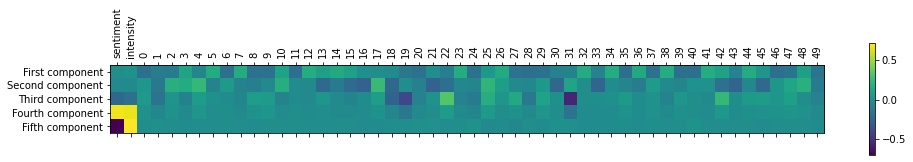

In [47]:
# now instead of having around 50 features, we have just 5
# is good to keep in mind that we are losing our capability of reading the features, but we are condensing information

plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1, 2,3,4], ["First component", "Second component","Third component","Fourth component","Fifth component"])
plt.colorbar()
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.show()

In [206]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import numpy as np

# r2 = r2_score(X, X_pca)
# rmse = sqrt(mean_squared_error(X, X_pca))

# # RMSE normalised by mean:
# nrmse = rmse/sqrt(np.mean(X**2))

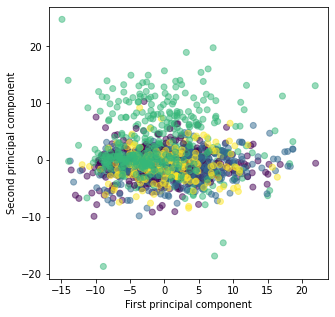

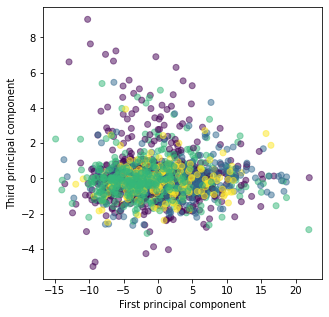

In [48]:
# lets look at the distribution of this features with the coloring of our politics
# impressive right?
# however, the human eye cannot capture more than 3 dimensions, so the visability is very difficult

import matplotlib.pyplot as plt


plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0],X_pca[:, 1], c=y,alpha=0.5)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0],X_pca[:, 2], c=y,alpha=0.5)
plt.xlabel("First principal component")
plt.ylabel("Third principal component")
plt.show()

In [52]:
# we now want to use a algorithm to cluster our tweets
# the objective here is quite simple
# we want something that tells us the topics of the tweets

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score

kmeans = cluster.KMeans(n_clusters=6) # using the elbow method we saw that 7 is the ideal number for clusters
kmeans.fit(X_pca)
pred = kmeans.predict(X_pca)

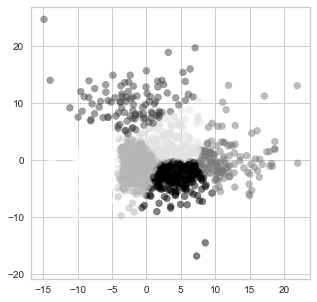

In [53]:
# as i said, we have 5 components and seeing them all at once with our poor human eyes is impossible!

plt.figure(figsize=(5, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred,alpha=0.5) # this is the plot using the first and second component
plt.show()

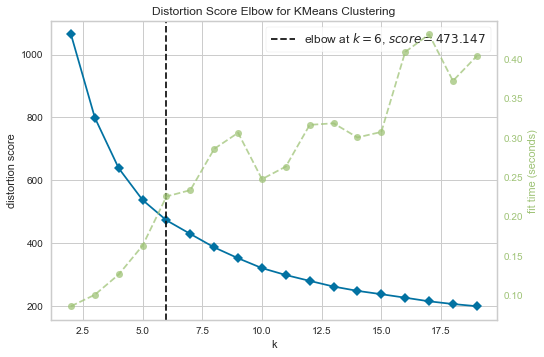

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
# this is the elbow that i mentioned that told me how many clusters i would be using


from yellowbrick.cluster import KElbowVisualizer

model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(X)
visualizer.poof()

In [54]:
# now to further improve our analysis we are going to be using the cluster centers, called centroids

centroids = kmeans.cluster_centers_
centroids

array([[-6.71277169e+00, -8.26059425e-01,  6.12964912e-02,
        -4.25090037e-03,  2.07953503e-02],
       [ 3.55697586e+00,  2.33898043e+00,  8.03256499e-02,
        -1.37906991e-01, -7.77514005e-02],
       [-1.59861199e+00, -8.97144051e-01, -6.78299728e-02,
        -7.02148600e-02, -1.91209502e-02],
       [ 1.15661904e+01,  1.82476017e-01,  3.44678378e-02,
        -1.13351381e-02,  1.71605608e-02],
       [-2.04660939e+00,  1.01212694e+01,  1.14918093e-01,
         1.92208382e-01,  2.38832713e-02],
       [ 4.18952710e+00, -2.97085373e+00, -6.71647224e-02,
         1.94610958e-01,  5.87036584e-02]])

In [55]:
# and we are calculating the centroid distance to every tweet, keep this in our pocket i are going to use it soon

from scipy.spatial.distance import cdist
dm = cdist(X_pca, centroids)
centroid_distance = pd.DataFrame(dm)

In [56]:
# the so told matrix of distances

centroid_distance

,0,1,2,3,4,5
0,23.555513,13.650163,18.445293,5.418644,21.811660,12.874851
1,8.951627,2.794790,4.371871,9.905042,9.950220,4.977278
2,15.365949,5.346767,10.306456,3.136123,14.283980,5.743887
3,5.519218,5.777807,1.671885,13.092582,10.498755,6.488393
4,8.313715,6.477715,4.209720,11.399738,13.652725,4.162279
...,...,...,...,...,...,...
1622,4.410649,9.131467,3.457002,15.513637,13.457890,7.842205
1623,4.589343,8.590860,2.915730,14.984738,13.291026,7.367335
1624,4.040151,9.495004,3.973903,16.127808,13.052752,8.647343
1625,7.551363,4.997725,3.462265,11.663650,10.702603,5.583392


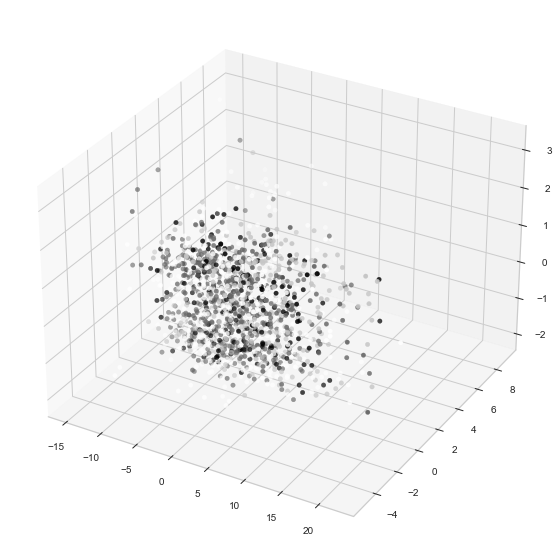

In [57]:
# projecting here some components in 3d (the most that we can see)

plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 2], X_pca[:, 3], c=y)
plt.show()

In [66]:
# we now should explore what each categorie actually is
# for that lets merge our features with the tweets text

tweet_info = features.merge(new_df, on='index')
tweet_info = tweet_info[['text_processed','text_preprocessed','labels','target_x']]

In [67]:
# the formula is the same for every cluster

# we going to print 10 elements of each tweet just to get a granular view of the cluster

counter = 0

for element in tweet_info[tweet_info['labels'] == 0]['text_preprocessed']:
    counter += 1
    if counter < 10:
        print(element)

talk revisionist history remember morningmika joenbc talk pete buttigieg caign try get viewer lean way please talk confidence morning joe msnbc
guarantee flee country traitor also fukkin moron
break biden doj step issue guideline caution state perform audit election result stolenpresidency trump presidenttrump news voterfraud chinavirus covid
must see thousand trump supporter chant trump trump trump greet pennsylvania video stolenpresidency trump presidenttrump news voterfraud chinavirus covid
year old asian woman drag nyc subway stair dy brain surgery trump presidenttrump news voterfraud chinavirus covid
boom rep elise stefanik come liz cheney pelosi pawn point represent republican conference video stolenpresidency trump presidenttrump news voterfraud chinavirus covid
begin st louis carpenter union force apprentice carpenter get vaccinate enter school trump presidenttrump news voterfraud chinavirus covid
inventor mrna vaccine covid vaccine make virus dangerous trump presidenttrump new

In [93]:
# then we going to use a lda model to extract the topic

theme_0 = list(tweet_info[tweet_info['labels'] == 0]['text_processed'])

theme_0

dictionary = gensim.corpora.Dictionary(theme_0)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_0]


In [94]:
# this is the model

lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 3)

In [95]:
# and this are the topics

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.012*"covid" + 0.010*"biden" + 0.010*"trump" + 0.007*"confirm" + 0.007*"hall" + 0.007*"like" + 0.006*"nothing" + 0.006*"news" + 0.006*"town" + 0.006*"diplomat"


Topic: 1 
Words: 0.019*"trump" + 0.012*"get" + 0.012*"covid" + 0.009*"biden" + 0.007*"america" + 0.007*"make" + 0.006*"democrat" + 0.006*"news" + 0.005*"donaldtrump" + 0.005*"vote"


Topic: 2 
Words: 0.013*"want" + 0.008*"president" + 0.008*"work" + 0.008*"go" + 0.007*"texas" + 0.007*"biden" + 0.007*"american" + 0.006*"get" + 0.006*"would" + 0.006*"gun"




In [96]:
counter = 0

for element in tweet_info[tweet_info['labels'] == 1]['text_preprocessed']:
    counter += 1
    if counter < 10:
        print(element)

elder abuse simple yet medium protection racket hide comically bizarre gaffe
secretary state visit south asian giant let liberal detractor pm read india asia democracy
secretary state visit south asian giant let liberal detractor pm read india asia democracy
cnn cuomo unvaccinated ignorant arrogant misplace sense righteous indignation stolenpresidency trump presidenttrump news voterfraud chinavirus covid
capitol police officer give emotional january testimony anti trump defend kenosha riot iraq blm maga capitolpolice trumpsupporters riot
biden nominates huawei prosecutor key chinese export position huawei technews chineseexport
capitolpolice backtheblue january thcommission ashlibabbitt know care bluelivesmatter nancypelosi lizcheney adamkinzinger lapd officer suffer brain bleed blm riot felt like nobody back
addendum corroboration sexual assault accusation repeat call biden withdraw democratic primary restart
china appoints sharp tongue qin gang ambassador china usa qingang ambassador

In [97]:
theme_1 = list(tweet_info[tweet_info['labels'] == 1]['text_processed'])

theme_1

dictionary = gensim.corpora.Dictionary(theme_1)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_1]


In [325]:
#dictionary.filter_extremes(no_below=2, no_above=0.5)

In [98]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 3)

In [99]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.018*"gop" + 0.018*"foxnews" + 0.017*"maga" + 0.015*"variant" + 0.014*"cnn" + 0.014*"delta" + 0.014*"kevinmccarthy" + 0.014*"rondesantis" + 0.014*"gregabbott" + 0.013*"dougducey"


Topic: 1 
Words: 0.009*"knew" + 0.006*"trump" + 0.006*"january" + 0.005*"get" + 0.005*"state" + 0.004*"kevinmccarthy" + 0.004*"jan" + 0.004*"like" + 0.003*"joshhawley" + 0.003*"go"


Topic: 2 
Words: 0.008*"trump" + 0.006*"biden" + 0.006*"cnn" + 0.006*"gop" + 0.004*"new" + 0.004*"also" + 0.003*"potus" + 0.003*"democrat" + 0.003*"brand" + 0.003*"voter"




In [100]:
counter = 0

for element in tweet_info[tweet_info['labels'] == 2]['text_preprocessed']:
    counter += 1
    if counter < 10:
        print(element)

video father son hunterbiden crackhead crack maga covid
dream little dream let get billgates klausschwab covid task force fauci borisjohnson scottmorrison jacindaardern everyone participate vaxlive albertbourla alexgorsky pascalsoriot jail coronavirus cabal wreckingball
raise eyebrow claim use drive wheeler truck foxnews cnn msnbc nbc wth losingit
felt many discrimination lgbt black people japan hate astrazeneca hate south korea selfishness anyone able organise fair safe world every country world finalnd
infrastructure deal senate suddenly act take bill senate democrat gop digital education economy road healthcare housing americanfamiliesplan infrastructurebill petebuttigieg energy tax job
secretary state visit south asian giant let liberal detractor pm read india asia democracy
secretary state visit south asian giant let liberal detractor pm read india asia democracy
remember time say butt wipe mybuttsbeenwiped bidenremorse bidenbordercrisis
middle name jeopardy trivia


In [117]:
theme_2 = list(tweet_info[tweet_info['labels'] == 2]['text_processed'])

theme_2

dictionary = gensim.corpora.Dictionary(theme_2)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_2]

In [102]:
#dictionary.filter_extremes(no_below=2, no_above=0.5)

In [118]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 15,
                                   workers = 3)

In [119]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.009*"trump" + 0.009*"texas" + 0.008*"biden" + 0.006*"covid" + 0.006*"gop" + 0.006*"get" + 0.006*"say" + 0.006*"president" + 0.005*"cnn" + 0.005*"make"


Topic: 1 
Words: 0.007*"trump" + 0.007*"biden" + 0.006*"say" + 0.005*"covid" + 0.005*"get" + 0.004*"work" + 0.004*"like" + 0.004*"sen" + 0.004*"go" + 0.004*"democrat"


Topic: 2 
Words: 0.008*"trump" + 0.006*"like" + 0.005*"senate" + 0.005*"covid" + 0.005*"want" + 0.005*"potus" + 0.005*"democrat" + 0.004*"people" + 0.004*"america" + 0.004*"one"




In [120]:
counter = 0

for element in tweet_info[tweet_info['labels'] == 3]['text_preprocessed']:
    counter += 1
    if counter < 50:
        print(element)

brexit eu uk criticise flaw protocol approach brexit northernireland belfast scotland dup ursulavonderleyen michelbarnier davidfrost eu michaelgove borisjohnson economy cornwall tradewar
palestinian attend funeral child muhammad al alami shot israeli occupation force afternoon entrance beitummar town north hebron freepalestine palestine boycottisrael bd apartheid israel naftalibennett
zero fail fascinate upset history secretservice begin jfk concludes inauguration book also indictment agency drunken frat boy culture seem dominate
barack obama join nba promote gender equality social responsibility africa stolenpresidency trump presidenttrump news voterfraud chinavirus covid
israeli army detains palestinian include minor westbank imemc news hebron bethlehem jenin stopannexation freepalestine palestine boycottisrael bd apartheid israel naftalibennett kamalaharris cnn foxnews
intosecurity daily podcast examines report cost databreaches cloud misconfigurations lead data breach tough rhetori

In [121]:
theme_3 = list(tweet_info[tweet_info['labels'] == 3]['text_processed'])

theme_3

dictionary = gensim.corpora.Dictionary(theme_3)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_3]

In [122]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 15,
                                   workers = 3)

In [123]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.004*"right" + 0.003*"call" + 0.003*"cnn" + 0.003*"aoc" + 0.003*"cuba" + 0.003*"texas" + 0.003*"want" + 0.003*"protest" + 0.003*"china" + 0.003*"invest"


Topic: 1 
Words: 0.007*"trump" + 0.005*"foxnews" + 0.004*"gop" + 0.004*"like" + 0.003*"delta" + 0.003*"maga" + 0.003*"msnbc" + 0.003*"gregabbott" + 0.003*"get" + 0.003*"eu"


Topic: 2 
Words: 0.008*"knew" + 0.007*"trump" + 0.004*"join" + 0.004*"ninaturner" + 0.004*"get" + 0.003*"kamalaharris" + 0.003*"barackobama" + 0.003*"blm" + 0.003*"aoc" + 0.003*"hillaryclinton"




In [124]:
counter = 0

for element in tweet_info[tweet_info['labels'] == 4]['text_preprocessed']:
    counter += 1
    if counter < 10:
        print(element)

climatechange link climate change climate change global warm
cdc say vaccinate people still spread covid delta variant mask require indoors democrat keep attack unvaccinated
maketuckerpay madmanmccarthy maga trump desantis pandumbmic twin newsmax mitchmcconnell billlee rondesantis mikeparson kristinoem delta variant dougducey cnn marcorubio gop jan attack gregabbott msnbc foxnews texas get vaxx arizona florida
maketuckerpay madmanmccarthy maga trump desantis pandumbmic twin newsmax mitchmcconnell billlee rondesantis mikeparson kristinoem delta variant dougducey cnn marcorubio gop jan attack gregabbott msnbc foxnews texas get vaxx arizona florida
madmanmccarthy maga trump desantis pandumbmic twin newsmax mitchmcconnell billlee rondesantis mikeparson kristinoem delta variant dougducey marcorubio gop jan attack gregabbott majorietaylorgreene msnbc foxnews texas get vaxx arizona florida
madmanmccarthy maga trump desantis pandumbmic twin newsmax mitchmcconnell billlee rondesantis mikeparson

In [125]:
theme_4 = list(tweet_info[tweet_info['labels'] == 4]['text_processed'])

theme_4

dictionary = gensim.corpora.Dictionary(theme_4)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_4]

In [126]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 15,
                                   workers = 3)

In [127]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.036*"gop" + 0.033*"gregabbott" + 0.033*"foxnews" + 0.032*"rondesantis" + 0.032*"maga" + 0.031*"delta" + 0.031*"variant" + 0.029*"dougducey" + 0.029*"msnbc" + 0.028*"kevinmccarthy"


Topic: 1 
Words: 0.032*"mikeparson" + 0.032*"mitchmcconnell" + 0.032*"marcorubio" + 0.032*"maga" + 0.032*"foxnews" + 0.031*"gop" + 0.031*"kristinoem" + 0.031*"dougducey" + 0.031*"variant" + 0.031*"delta"


Topic: 2 
Words: 0.030*"foxnews" + 0.029*"tatereeves" + 0.029*"majorietaylorgreene" + 0.028*"laurenboebert" + 0.028*"kevinmccarthy" + 0.028*"rondesantis" + 0.028*"variant" + 0.028*"delta" + 0.028*"maga" + 0.027*"jan"




In [128]:
counter = 0

for element in tweet_info[tweet_info['labels'] == 5]['text_preprocessed']:
    counter += 1
    if counter < 10:
        print(element)

thursdaythoughts blame freudian slip late blunder confuses obama trump biden new song always mind biden never escape shadow patriot presidenttrump maga trump potus
democrat tear monument convince people victim claim systemicracism institute segregation pit one race another push defundthepolice yet claim unify america lliberalhypocrisy blacklivesmatter liberallies
judicial watch new document reveal cdc coordinate facebook covid message allege misinformation trump presidenttrump news voterfraud chinavirus covid judicialwatch
antifa goon get beat israel rally socal video trump presidenttrump news voterfraud chinavirus covid
liberal news network ignore assault robbery former senator barbara boxer california stolenpresidency trump presidenttrump news voterfraud chinavirus covid barbaraboxer
democrat massive amnesty prospect fade kyrsten sinema opposition budget stolenpresidency trump presidenttrump news voterfraud chinavirus covid
biden mask erade hit pentagon individual order mask regardle

In [129]:
theme_5 = list(tweet_info[tweet_info['labels'] == 5]['text_processed'])

theme_5

dictionary = gensim.corpora.Dictionary(theme_5)
bow_corpus = [dictionary.doc2bow(doc) for doc in theme_5]

In [130]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 20,
                                   workers = 3)

In [131]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.008*"biden" + 0.007*"work" + 0.005*"say" + 0.005*"support" + 0.005*"aoc" + 0.004*"help" + 0.004*"time" + 0.004*"take" + 0.004*"covid" + 0.004*"trump"


Topic: 1 
Words: 0.006*"like" + 0.005*"go" + 0.004*"get" + 0.004*"say" + 0.004*"think" + 0.004*"gop" + 0.004*"call" + 0.003*"aoc" + 0.003*"would" + 0.003*"vote"


Topic: 2 
Words: 0.012*"trump" + 0.008*"covid" + 0.006*"would" + 0.005*"biden" + 0.005*"presidenttrump" + 0.005*"voterfraud" + 0.005*"news" + 0.005*"work" + 0.005*"chinavirus" + 0.004*"say"




In [147]:
# now we are going to start building our main analysis object

new_df = target_features_df[['index','target','sentiment','intensity']]

In [148]:
# attribute the predicted clusters to this new_df

new_df['labels'] = pred

<ipython-input-148-c69d4099eec9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['labels'] = pred


In [149]:
# add the distance to the centroids for every tweet
# keep in mind that the lowest distance is the label itself

new_df = pd.concat([new_df,centroid_distance], axis=1)

In [150]:
new_df

,index,target,sentiment,intensity,labels,0,1,2,3,4,5
0,0,#JoeBiden,0,2.074752,3,23.555513,13.650163,18.445293,5.418644,21.811660,12.874851
1,1,#JoeBiden,0,3.247204,1,8.951627,2.794790,4.371871,9.905042,9.950220,4.977278
2,2,#JoeBiden,0,1.852865,3,15.365949,5.346767,10.306456,3.136123,14.283980,5.743887
3,3,#JoeBiden,0,1.000000,2,5.519218,5.777807,1.671885,13.092582,10.498755,6.488393
4,4,#JoeBiden,0,2.686649,5,8.313715,6.477715,4.209720,11.399738,13.652725,4.162279
...,...,...,...,...,...,...,...,...,...,...,...
1622,1635,#TedCruz,1,2.790570,2,4.410649,9.131467,3.457002,15.513637,13.457890,7.842205
1623,1636,#TedCruz,0,1.503812,2,4.589343,8.590860,2.915730,14.984738,13.291026,7.367335
1624,1637,#TedCruz,1,3.692931,2,4.040151,9.495004,3.973903,16.127808,13.052752,8.647343
1625,1638,#TedCruz,1,3.692931,2,7.551363,4.997725,3.462265,11.663650,10.702603,5.583392


In [136]:
# we have now something like this
# by grouping the target and labels, counting the amount of tweets in each cluster, an then the average distance to the centroids

new_df.groupby(['target','labels']).agg({'labels':'count','sentiment':'mean','intensity':'mean',0:'mean',1:'mean',2:'mean',3:'mean',4:'mean',5:'mean'})

labels  sentiment  intensity          0          1  \
target         labels                                                       
#BernieSanders 0           60   0.416667   1.756144   3.416294  11.345345   
               1           49   0.387755   1.809217  11.129455   2.821411   
               2          106   0.433962   1.692768   5.854037   6.503867   
               3           49   0.469388   2.275213  18.718205   9.081177   
               5           79   0.607595   2.405912  11.703740   6.234597   
#JoeBiden      0          137   0.335766   1.746733   3.431701  11.344121   
               1           69   0.246377   1.714262  10.460535   3.050400   
               2          210   0.323810   1.874488   5.709903   6.710648   
               3           36   0.277778   1.953007  18.219958   8.741320   
               4            4   0.250000   1.475100   8.784672  10.157178   
               5           93   0.344086   2.105021  11.321886   5.877978   
#MikePence     0           41   0.365854   1.877283   3.388897  10.683176   
               1           24   0.250000   2.159344  11.193247   2.977249   
               2           73   0.383562   2.020889   5.895507   6.804252   
               3           18   0.277778   2.311754  17.704145   8.419775   
               4            3   0.333333   2.207791   9.667119   7.780194   
               5           42   0.333333   2.324186  11.358642   5.905717   
#TedCruz       0          113   0.327434   1.894209   3.073586  10.978066   
               1           80   0.300000   1.925598  11.584374   3.720462   
               2          161   0.354037   1.970852   5.737239   6.346549   
               3           28   0.321429   2.441642  19.744699   9.968666   
               4           96   0.229167   1.797409  12.910179  10.613493   
               5           56   0.553571   2.247590  11.561490   6.451139   

                               2          3          4          5  
target         labels                                              
#BernieSanders 0        5.911061  18.564762  12.967848  11.355015  
               1        6.393278   7.896376  10.935402   4.910685  
               2        2.721459  13.333386  11.441247   6.512678  
               3       13.701677   4.010052  17.469365   8.638019  
               5        7.001935   8.267039  14.974575   3.239207  
#JoeBiden      0        6.141164  18.707633  12.465249  11.680166  
               1        6.009127   8.948187  10.134998   5.534943  
               2        2.768820  13.550266  11.394855   6.736511  
               3       13.184787   3.737533  17.394444   8.012581  
               4        9.183996  18.156675   5.156155  13.938639  
               5        6.671481   8.554657  14.514553   3.327909  
#MikePence     0        5.570544  18.082094  11.950140  11.104545  
               1        6.631660   8.297131  10.270012   5.837047  
               2        2.898509  13.416797  11.846025   6.441435  
               3       12.733880   4.073355  16.952224   7.677341  
               4        8.489961  15.512529   3.616048  12.196136  
               5        6.609573   8.473644  14.611137   3.206004  
#TedCruz       0        5.941804  18.583598  11.532102  11.721987  
               1        7.423905   9.243304   9.245229   7.110823  
               2        2.814850  13.430455  10.728919   6.851989  
               3       14.908788   5.839403  17.105655  10.489657  
               4       12.084868  17.377338   5.027147  15.288602  
               5        6.875692   8.894141  15.108754   3.487094

In [158]:
# we dont want to show every single value, we want only the cluster that we are talking about.

clean = new_df.groupby(['target','labels']).agg({'labels':'count','sentiment':'mean','intensity':'mean',0:'mean',1:'mean',2:'mean',3:'mean',4:'mean',5:'mean'})
clean = clean.rename(columns={'labels':'cluster'})
clean = clean.reset_index()
melted = pd.melt(clean,id_vars =['target','labels','cluster','sentiment','intensity'])
melted = melted[melted['labels']==melted['variable']]
melted = melted.sort_values(['target','labels'])
melted = melted.rename(columns={'target':'politician','labels':'topic','cluster':'tweet_count','value':'topic_affinity'})
melted.drop(columns='variable',inplace=True)
melted

,politician,topic,tweet_count,sentiment,intensity,topic_affinity
0,#BernieSanders,0,60,0.416667,1.756144,3.416294
24,#BernieSanders,1,49,0.387755,1.809217,2.821411
48,#BernieSanders,2,106,0.433962,1.692768,2.721459
72,#BernieSanders,3,49,0.469388,2.275213,4.010052
119,#BernieSanders,5,79,0.607595,2.405912,3.239207
5,#JoeBiden,0,137,0.335766,1.746733,3.431701
29,#JoeBiden,1,69,0.246377,1.714262,3.050400
53,#JoeBiden,2,210,0.323810,1.874488,2.768820
77,#JoeBiden,3,36,0.277778,1.953007,3.737533
101,#JoeBiden,4,4,0.250000,1.475100,5.156155


In [159]:
# this are the topics that we have seen in our LDAMulticore models


def topics(row):
    if row == 0:
        return 'Covid'
    elif row == 1:
        return 'GOP + McCarthy + 6th January'
    elif row == 2:
        return 'Trump + Texas + Senate'
    elif row == 3:
        return 'Cuba Protest + China'
    elif row == 4:
        return 'Delta Variant'
    elif row == 5:
        return 'Biden + AOC'

melted['topic'] = melted['topic'].apply(topics)

In [160]:
# so we can visualize the centroids better, we are going to change the values

def affinity(row):
    return 10 - row

In [161]:
melted['topic_affinity'] = melted['topic_affinity'].apply(affinity)

In [162]:
# purely for presentation intent, we are going to cut the values, so
# the audience can visualize better the results


melted = melted.sort_values(['topic','tweet_count'], ascending=False)

labels = ["Low", "Moderate", "High"]

qbins = pd.qcut(melted['intensity'],3, labels=labels)

melted['intensity'] = qbins

melted

,politician,topic,tweet_count,sentiment,intensity,topic_affinity
53,#JoeBiden,Trump + Texas + Senate,210,0.323810,Low,7.231180
65,#TedCruz,Trump + Texas + Senate,161,0.354037,Moderate,7.185150
48,#BernieSanders,Trump + Texas + Senate,106,0.433962,Low,7.278541
59,#MikePence,Trump + Texas + Senate,73,0.383562,Moderate,7.101491
41,#TedCruz,GOP + McCarthy + 6th January,80,0.300000,Moderate,6.279538
29,#JoeBiden,GOP + McCarthy + 6th January,69,0.246377,Low,6.949600
24,#BernieSanders,GOP + McCarthy + 6th January,49,0.387755,Low,7.178589
35,#MikePence,GOP + McCarthy + 6th January,24,0.250000,High,7.022751
113,#TedCruz,Delta Variant,96,0.229167,Low,4.972853
101,#JoeBiden,Delta Variant,4,0.250000,Low,4.843845


In [163]:
labels = ["Low", "Moderate", "High"]

qbins = pd.qcut(melted['topic_affinity'],3, labels=labels)

melted['topic_affinity'] = qbins

melted

,politician,topic,tweet_count,sentiment,intensity,topic_affinity
53,#JoeBiden,Trump + Texas + Senate,210,0.323810,Low,High
65,#TedCruz,Trump + Texas + Senate,161,0.354037,Moderate,High
48,#BernieSanders,Trump + Texas + Senate,106,0.433962,Low,High
59,#MikePence,Trump + Texas + Senate,73,0.383562,Moderate,High
41,#TedCruz,GOP + McCarthy + 6th January,80,0.300000,Moderate,Low
29,#JoeBiden,GOP + McCarthy + 6th January,69,0.246377,Low,High
24,#BernieSanders,GOP + McCarthy + 6th January,49,0.387755,Low,High
35,#MikePence,GOP + McCarthy + 6th January,24,0.250000,High,High
113,#TedCruz,Delta Variant,96,0.229167,Low,Low
101,#JoeBiden,Delta Variant,4,0.250000,Low,Low


In [164]:
# is it correct to say that 0.49 is negative?
# is it correct to say that 0.51 is positive?
# well, i would say not exactly, so i decided to cut this values
# and do an abstract interpretation of what is considered neutral.

labels = ["Negative", "Neutral", "Positive"]

qbins = pd.cut(melted['sentiment'],3, labels=labels)

melted['sentiment'] = qbins

melted

,politician,topic,tweet_count,sentiment,intensity,topic_affinity
53,#JoeBiden,Trump + Texas + Senate,210,Negative,Low,High
65,#TedCruz,Trump + Texas + Senate,161,Negative,Moderate,High
48,#BernieSanders,Trump + Texas + Senate,106,Neutral,Low,High
59,#MikePence,Trump + Texas + Senate,73,Neutral,Moderate,High
41,#TedCruz,GOP + McCarthy + 6th January,80,Negative,Moderate,Low
29,#JoeBiden,GOP + McCarthy + 6th January,69,Negative,Low,High
24,#BernieSanders,GOP + McCarthy + 6th January,49,Neutral,Low,High
35,#MikePence,GOP + McCarthy + 6th January,24,Negative,High,High
113,#TedCruz,Delta Variant,96,Negative,Low,Low
101,#JoeBiden,Delta Variant,4,Negative,Low,Low
